# Optimizing a data center operation

## Necessary functions

Import necessary packages needed to process the data

In [15]:
import pandas as pd
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [17]:
def get_known(key):
    # STORE SOME CONFIGURATION VARIABLES
    if key == 'datacenter_id':
        return ['DC1',
                'DC2',
                'DC3',
                'DC4']
    elif key == 'actions':
        return ['buy',
                'hold',
                'move',
                'dismiss']
    elif key == 'server_generation':
        return ['CPU.S1',
                'CPU.S2',
                'CPU.S3',
                'CPU.S4',
                'GPU.S1',
                'GPU.S2',
                'GPU.S3']
    elif key == 'latency_sensitivity':
        return ['high',
                'medium',
                'low']
    elif key == 'required_columns':
        return ['time_step',
                'datacenter_id',
                'server_generation',
                'server_id',
                'action']
    elif key == 'time_steps':
        return 168
    elif key == 'datacenter_fields':
        return ['datacenter_id',
                'cost_of_energy',
                'latency_sensitivity',
                'slots_capacity']

In [18]:
def get_random_walk(n, mu, sigma):
    # HELPER FUNCTION TO GET A RANDOM WALK TO CHANGE THE DEMAND PATTERN
    r = np.random.normal(mu, sigma, n)
    ts = np.empty(n)
    ts[0] = r[0]
    for i in range(1, n):
        ts[i] = ts[i - 1] + r[i]
    ts = (2 * (ts - ts.min()) / np.ptp(ts)) - 1
    return ts

In [19]:
def get_actual_demand(demand):
    # CALCULATE THE ACTUAL DEMAND AT TIME-STEP t
    actual_demand = []
    for ls in get_known('latency_sensitivity'):
        for sg in get_known('server_generation'):
            d = demand[demand['latency_sensitivity'] == ls]
            sg_demand = d[sg].values.astype(float)
            rw = get_random_walk(sg_demand.shape[0], 0, 2)
            sg_demand += (rw * sg_demand)

            ls_sg_demand = pd.DataFrame()
            ls_sg_demand['time_step'] = d['time_step']
            ls_sg_demand['server_generation'] = sg
            ls_sg_demand['latency_sensitivity'] = ls
            ls_sg_demand['demand'] = sg_demand.astype(int)
            actual_demand.append(ls_sg_demand)

    actual_demand = pd.concat(actual_demand, axis=0, ignore_index=True)
    actual_demand = actual_demand.pivot(index=['time_step', 'server_generation'], columns='latency_sensitivity')
    actual_demand.columns = actual_demand.columns.droplevel(0)
    actual_demand = actual_demand.loc[actual_demand[get_known('latency_sensitivity')].sum(axis=1) > 0]
    actual_demand = actual_demand.reset_index(['time_step', 'server_generation'], col_level=1, inplace=False)
    return actual_demand

## Problem Overview

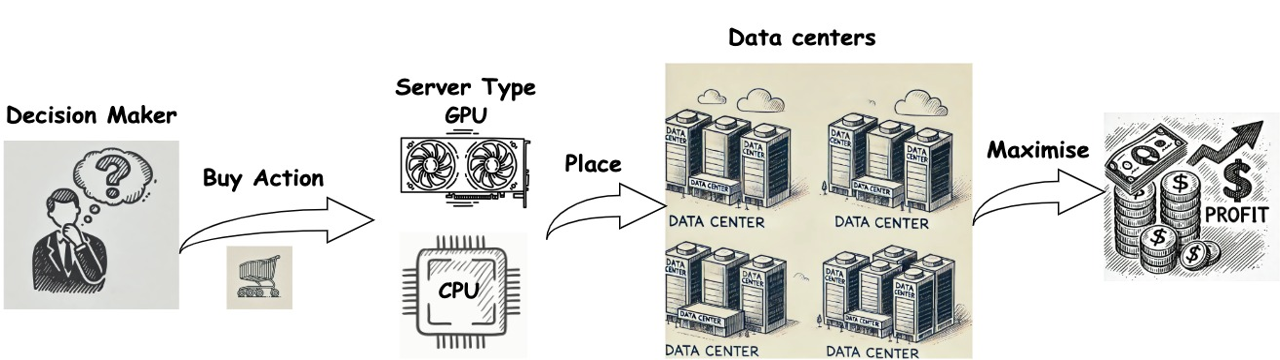

In [13]:
from PIL import Image
import requests
from io import BytesIO

img = Image.open(BytesIO(requests.get('https://github.com/Tayerquach/data_center_operations/blob/master/photo/buy_only.jpg?raw=true').content))
resized_img = img.resize((1280,360))
resized_img


**Data center operation management** is a combination of complex and challenging tasks. To better understand these challenges, we will break them down into smaller projects and address them step by step.


### Buy Only

In this scenario, there is one decision-maker responsible for managing four data centers. Each data center contains two types of servers: CPU servers and GPU servers. The decision-maker's objective is to maximize profit by purchasing servers at discrete time steps.

In [8]:
servers = pd.read_csv('https://github.com/Tayerquach/data_center_operations/blob/master/data/servers.csv?raw=true')
servers = servers[['server_generation', 'server_type', 'purchase_price']]
servers

,server_generation,server_type,purchase_price
0,CPU.S1,CPU,15000
1,CPU.S2,CPU,16000
2,CPU.S3,CPU,19500
3,CPU.S4,CPU,22000
4,GPU.S1,GPU,120000
5,GPU.S2,GPU,140000
6,GPU.S3,GPU,160000


For each seed number, we can generate a demand.

In [20]:
baseline_demand = pd.read_csv('https://github.com/Tayerquach/data_center_operations/blob/master/data/demand.csv?raw=true')
actual_demand = []
seed = 2381
# SET THE RANDOM SEED
np.random.seed(seed)
# GET THE DEMAND
actual_demand = get_actual_demand(baseline_demand)

In [21]:
actual_demand

latency_sensitivity,time_step,server_generation,high,low,medium
0,1,CPU.S1,6144,12075,8039
1,1,GPU.S1,22,4,15
2,2,CPU.S1,12818,21297,16556
3,2,GPU.S1,49,11,32
4,3,CPU.S1,17707,29525,24347
...,...,...,...,...,...
667,167,GPU.S3,3741,5385,911
668,168,CPU.S3,122497,401896,79215
669,168,CPU.S4,652327,1649200,521952
670,168,GPU.S2,326,679,344
